In [21]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later

criteria_dict = {"cs_name_val" : 12}
project = signac.get_project("GPBO_Fix")
save_csv = False
save_figs = False
analyzer = General_Analysis(criteria_dict, project, mode = "act", save_csv = save_csv)
plotters = Plotters(analyzer, save_figs)

def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data
    
def calc_mm_model(model_coefficients, x):
    """
    Caclulates the Muller Potential
    
    Parameters
    ----------
        model_coefficients: ndarray, The array containing the values of Muller constants
        x: ndarray, Values of X
        noise: ndarray, Any noise associated with the model calculation
    
    Returns:
    --------
        y_mul: float, value of Muller potential
    """    
    theta = model_coefficients
    # y_mul = (theta[0] * x**3 - theta[1] * x**2 + 2*x - 1)**2 + (theta[0] - theta[1])**2 + (x**2 - 1)**2 #MC Example
    # y_mul = theta[0]*(1 - theta[1]*np.exp(-theta[2]*x)) #Choline Chloride
    y_mul = -(theta[3]+theta[4])*np.exp(-theta[0]*x) + theta[3]*np.exp(-theta[1]*x) + theta[4]*np.exp(-theta[2]*x) #Ethyl Acrylate

    return y_mul

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - calc_mm_model(theta_guess,x); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(xx, yy, x, y):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(xx),len(yy)])
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i][j],yy[i][j]])
            sse[i][j] = sum((y - calc_cs1_polynomial(theta,x))**2) 
    
    return sse


In [22]:
#Choline Chloride
# param_name_str = "t1t2t3"
# indeces_to_consider = [0,1,2]
# bounds_x = np.array([[3], [8]])
# bounds_theta_l = [35.0,0.4, 0.01]
# bounds_theta_u = [45.0, 1.0, 0.5]
# theta_ref = np.array([39.09, 0.828, 0.159]) 
# theta_names = ['theta_1', 'theta_2', 'theta_3']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Ethyl Acrylate
param_name_str = "t1t2t3t4t5"
indeces_to_consider = [0,1,2,3,4]
bounds_x = np.array([[0], [4]])
bounds_theta_l = [1,0.1,0.01, 0.1, 0.001]
bounds_theta_u = [10, 1, 0.1, 1, 0.01]
theta_ref = np.array([3.025, 0.481, 0.0258, 0.310, 0.0011]) 
theta_names = ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5']
theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#MC Example
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[-2], [1.5]])
# bounds_theta_l = [-2,-2]
# bounds_theta_u = [2,2]
# theta_ref = np.array([-1.5, 0.5 ]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

[1.01915004e-17 1.51669585e-01 1.84630514e-01 1.77596769e-01
 1.58794460e-01 1.38103092e-01 1.18770787e-01 1.01679125e-01
 8.68912581e-02 7.42100454e-02]


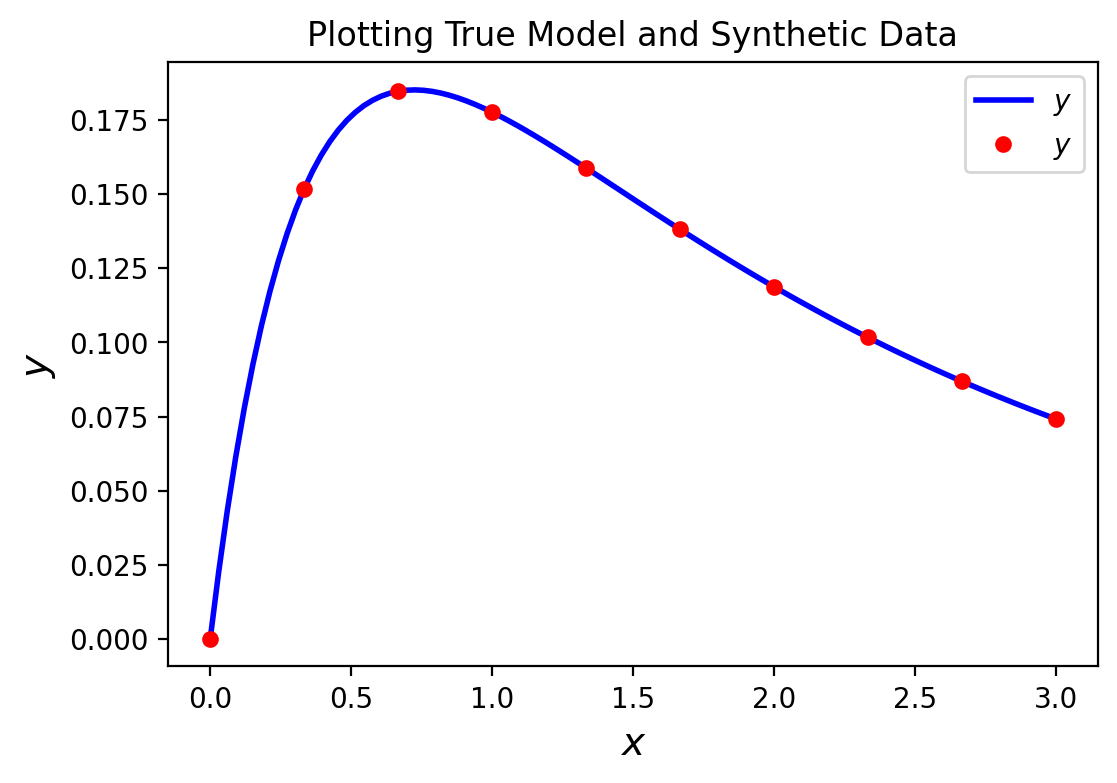

In [23]:


num_params = len(theta_ref)

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
num_points = 10 #len(Xexp)
Xexp = grid_sampling(num_points, bounds_x)
Yexp_org = np.array([ calc_mm_model(theta_ref, Xexp[i])  for i in range(len(Xexp)) ]).flatten()
std = 0 #np.mean(Yexp_org)*0.01
noise = np.random.normal(size=len(Yexp_org), loc = 0, scale = std)
Yexp = Yexp_org + noise
print(Yexp)
# Evaluate model based on the assumed experimental values
X = np.linspace(np.min(Xexp),np.max(Xexp),100).reshape(-1,1)
Y = calc_mm_model(theta_ref, X.reshape(-1,1))

# Compare the experiments to the true model
plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.plot(Xexp,Yexp,'r.',markersize=10,label=r"$y$")
plt.title("Plotting True Model and Synthetic Data")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()

In [24]:
##New Cell

## define function that includes nonlinear model
def model(theta_guess, theta_ref, x, indeces_to_consider):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Define an array to store y values in
    y_data = []
    #Loop over all theta values
    for i in range(len(x)):
        #Create model coefficient from true space substituting in the values of param_space at the correct indeces
        model_coefficients = theta_ref.copy()
        #Replace coefficients a specified indeces with their theta_val counterparts
        model_coefficients[indeces_to_consider] = theta_guess              
        #Create y data coefficients
        y = calc_mm_model(model_coefficients, x[i])
        y_data.append(y)
        # print(model_coefficients, x[i], y)

    #Convert list to array and flatten array
    y_model = np.array(y_data).flatten()
    
    return y_model

print(model(theta_true, theta_true, Xexp, indeces_to_consider))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, theta_ref, x, indeces_to_consider, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    error = y - model(theta_guess, theta_ref, x, indeces_to_consider) #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

print(regression_func(theta_true, theta_true, Xexp, indeces_to_consider, Yexp))

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(theta_guesses, theta_ref, indeces_to_consider, Xexp, Yexp):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Initialize sse grid
    sse = np.zeros(len(theta_guesses))
    
    #For each guess
    for i in range(len(theta_guesses)):
        #Evaluate the model
        y_sim = model(theta_guesses[i], theta_ref, Xexp, indeces_to_consider)
        #Calculate SSE
        sse[i] = np.sum((y_sim - Yexp)**2)
     
    sse = sse.reshape(int(np.sqrt(len(theta_guesses))), -1).T
    
    return sse

print(sse_func([theta_true], theta_true, indeces_to_consider, Xexp, Yexp))

[1.01915004e-17 1.51669585e-01 1.84630514e-01 1.77596769e-01
 1.58794460e-01 1.38103092e-01 1.18770787e-01 1.01679125e-01
 8.68912581e-02 7.42100454e-02]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0.]]


In [25]:
#New Cell
# Create synthetic data assuming the following values for theta
Theta_Guess = np.array([1,1])

# print(calc_cs1_polynomial(Theta_Guess,Xexp))
## specify initial guess
sse_list = []
opt_list = []
theta_list = []

## specify bounds
lower = np.array([bounds_theta_l[i] for i in indeces_to_consider] )
upper = np.array([bounds_theta_u[i] for i in indeces_to_consider] )
bounds = (lower, upper)

    ## specify initial guesses
    
    # 
for i in range(1000):
    theta_guess = np.random.uniform(low=lower, high=upper, size=len(lower) )
    # print(theta_guess)
    Solution = optimize.least_squares(regression_func, theta_guess, bounds=bounds, method='trf',
                                        args=(theta_true, Xexp.reshape(-1,1), indeces_to_consider, Yexp),verbose=0)


    theta = Solution.x
    sse_list.append(Solution.cost)
    theta_list.append(theta)
    opt_list.append(Solution.optimality)
    # print("theta = ",theta)

all_sets = pd.DataFrame({'Theta': theta_list, 'SSE': sse_list, 'Optimality': opt_list})

# print(all_sets)
#Organize all_sets by SSE, lowest to highest
all_sets = all_sets.sort_values(by="SSE", ascending=True)

# # Drop duplicate minima
all_sets = all_sets.drop_duplicates(
    subset="SSE", keep="first")
# # Drop minima with optimality > 1e-4
all_sets = all_sets[all_sets["Optimality"] < 1e-4]

In [26]:
#Scale values between 0 and 1 with minmax scaler
scaler = MinMaxScaler()
scaler.fit([bounds_theta_l, bounds_theta_u])
all_param_sets = np.array(list(map(np.array, all_sets["Theta"].values)))
all_param_sets_scaled = scaler.transform(all_param_sets)
#Calculate the scaled euclidean distance between each pair of scaled points
dist = pdist(all_param_sets_scaled)/np.sqrt(all_param_sets.shape[1])
#Convert the condensed distance matrix to square form
dist_sq = squareform(dist)

#Initialize a boolean array to keep track of unique sets
unique_mask = np.ones(all_param_sets.shape[0], dtype=bool)

# Iterate over the upper triangle of the distance matrix
for i in range(all_param_sets.shape[0]):
    # If the current set is already marked as non-unique, skip it
    if not unique_mask[i]:
        continue
    # Mark sets within the threshold distance as non-unique
    within_threshold = dist_sq[i] <= 0.01
    unique_mask[within_threshold] = False
    unique_mask[i] = True  # Keep the current set

# Filter out the unique sets from the pandas df
local_min_sets = all_sets[unique_mask]

print("Num local min", len(local_min_sets))

print(local_min_sets["Theta"].values)

# print(all_sets)print("Best Theta = ", nlr_theta)
nlr_theta = local_min_sets.iloc[0]['Theta']

print("Best Theta = ", nlr_theta)
print("theta_ref", theta_true)
Y_nlr_exp = model(nlr_theta, theta_true, Xexp, indeces_to_consider)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))

Num local min 54
[array([3.02500002e+00, 4.80999802e-01, 2.57752185e-02, 3.10000162e-01,
        1.09983054e-03])
 array([3.02500466e+00, 4.80987457e-01, 2.44983184e-02, 3.10008526e-01,
        1.09058685e-03])
 array([3.02499413e+00, 4.81014146e-01, 2.72113696e-02, 3.09990634e-01,
        1.11043730e-03])
 array([3.02501022e+00, 4.80972396e-01, 2.29198704e-02, 3.10018735e-01,
        1.07931692e-03])
 array([3.02498760e+00, 4.81032422e-01, 2.90963655e-02, 3.09977959e-01,
        1.12436931e-03])
 array([3.02501488e+00, 4.80959984e-01, 2.16156923e-02, 3.10027065e-01,
        1.07010001e-03])
 array([3.02498332e+00, 4.81043572e-01, 3.02155601e-02, 3.09970328e-01,
        1.13280077e-03])
 array([3.02497821e+00, 4.81057191e-01, 3.15813137e-02, 3.09960913e-01,
        1.14317819e-03])
 array([3.02502147e+00, 4.80943531e-01, 1.99029742e-02, 3.10037866e-01,
        1.05807601e-03])
 array([3.02497546e+00, 4.81067582e-01, 3.27003684e-02, 3.09953140e-01,
        1.15154905e-03])
 array([3.025

In [27]:
#Create heat map data
#Create list of heat map theta data
heat_map_data_dict = {}

#Create a linspace for the number of dimensions and define number of points
dim_theta = num_params
dim_list = np.linspace(0, dim_theta-1, dim_theta)

#Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
n_points = 20

#Meshgrid set always defined by n_points**2
theta_set = np.tile(np.array(theta_ref), (n_points**2, 1))

#Set x_vals
norm_x_vals = Xexp.reshape(-1,1)

#Loop over all possible theta combinations of 2
for i in range(len(mesh_combos)):
    #Create a copy of the true values to change the mehsgrid valus on
    theta_set_copy = np.copy(theta_set)
    #Set the indeces of theta_set for evaluation as each row of mesh_combos
    idcs = mesh_combos[i]
    #define name of parameter set as tuple ("param_1,param_2")
    data_set_name = (theta_true_names[idcs[0]], theta_true_names[idcs[1]])

    #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
    #Assume that theta1 and theta2 have equal number of points on the meshgrid
    theta1 = np.linspace(lower[idcs[0]], upper[idcs[0]], n_points)
    theta2 = np.linspace(lower[idcs[1]], upper[idcs[1]], n_points)
    theta12_mesh = np.array(np.meshgrid(theta1, theta2))
    theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

    #Set initial values for evaluation (true values) to meshgrid values
    theta_set_copy[:,idcs] = theta12_vals
    
    #Append data set to dictionary with name
    heat_map_data_dict[data_set_name] = theta_set_copy
    
hm_data_keys = list(heat_map_data_dict.keys())

/scratch365/mcarlozo/Toy_Problem/bo_methods_lib/bo_methods_lib/GPBO_Classes_plotters.py:2171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


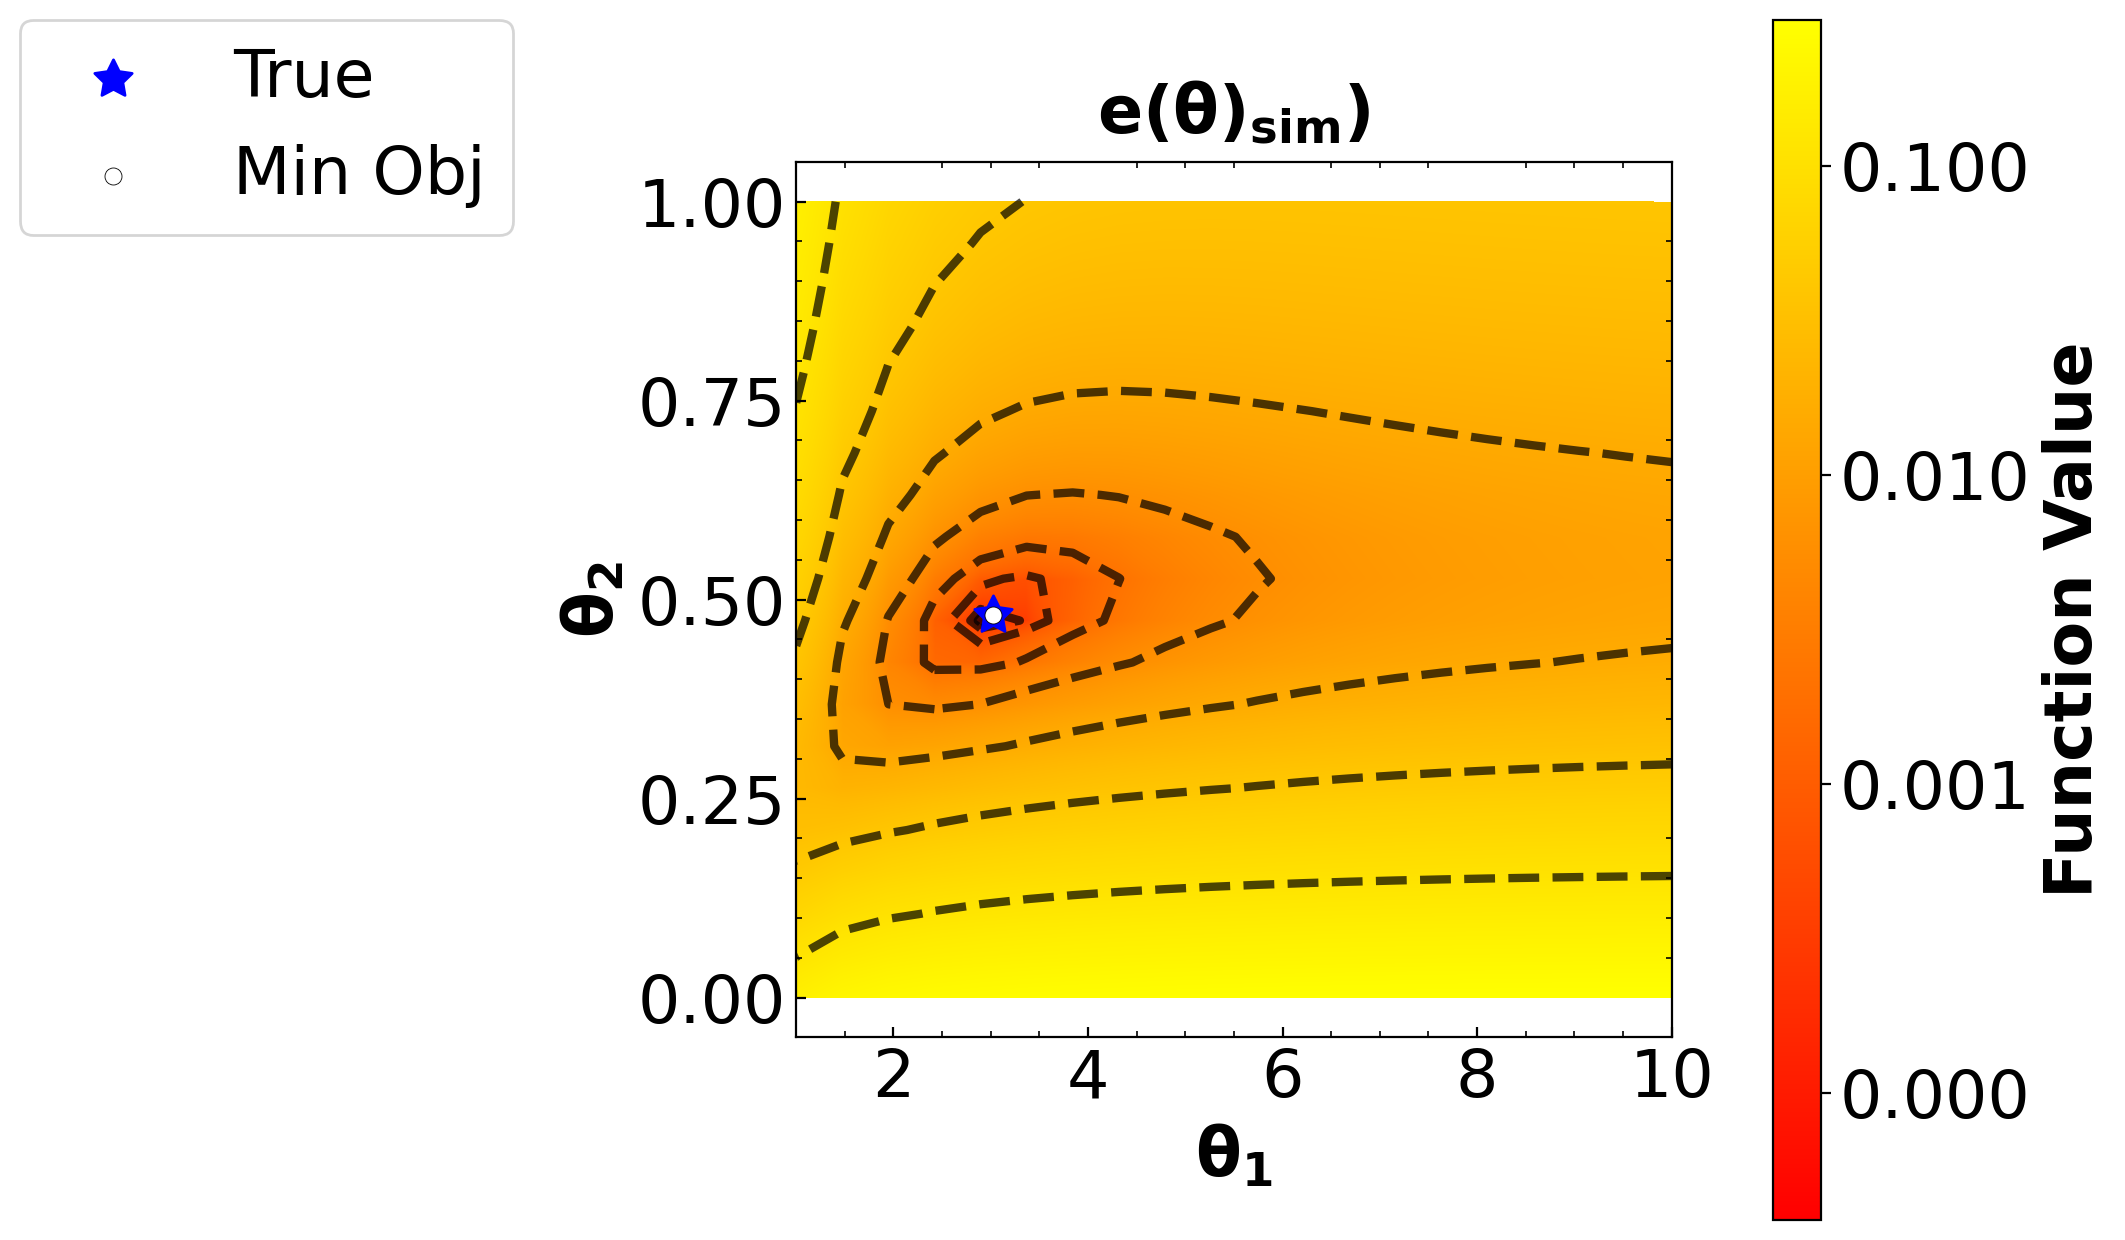

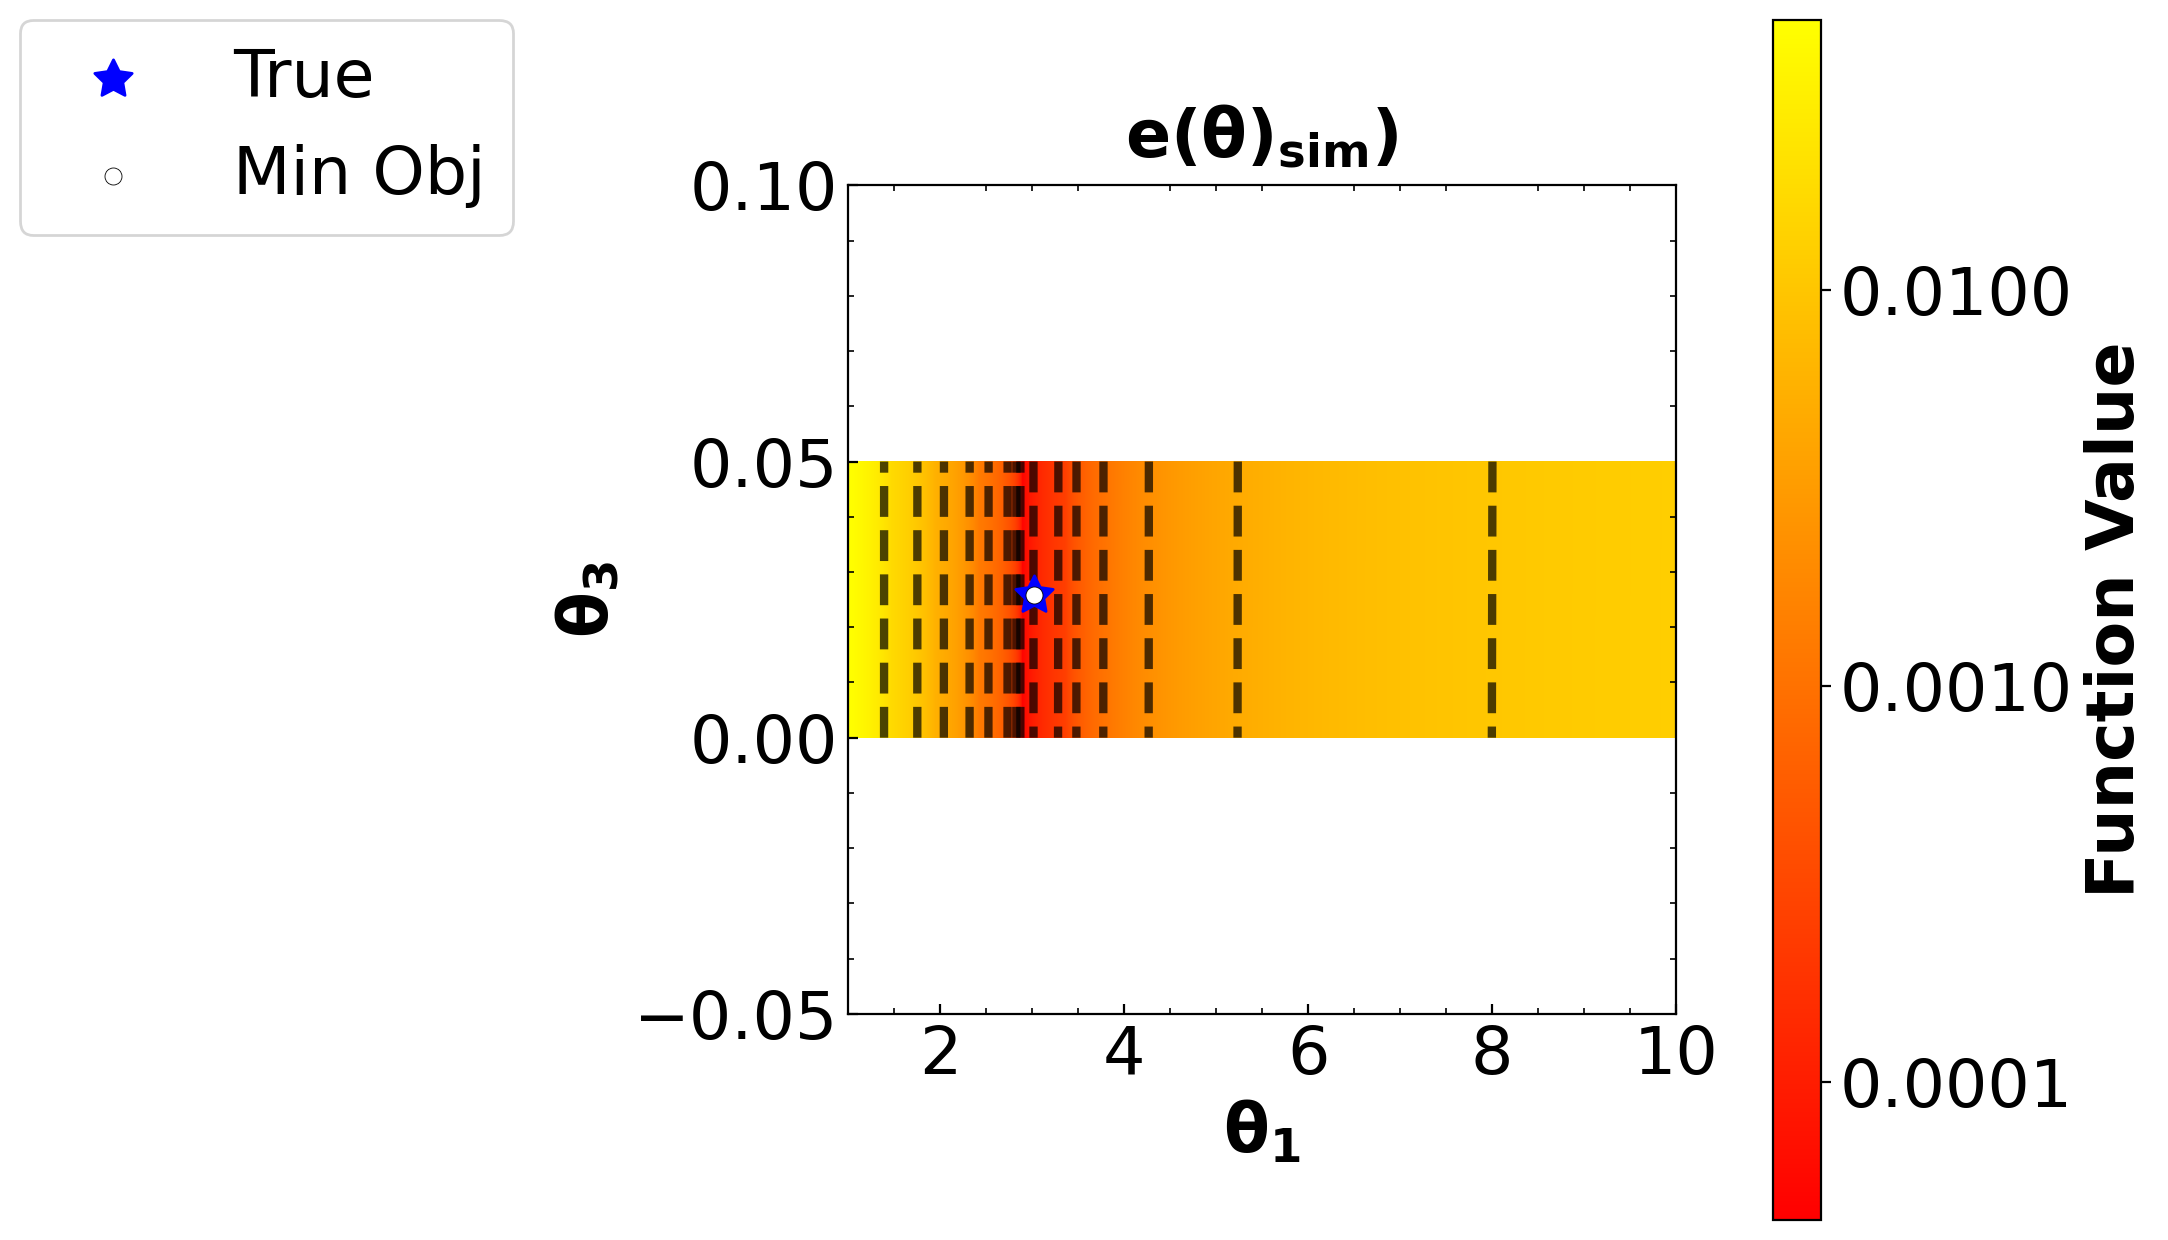

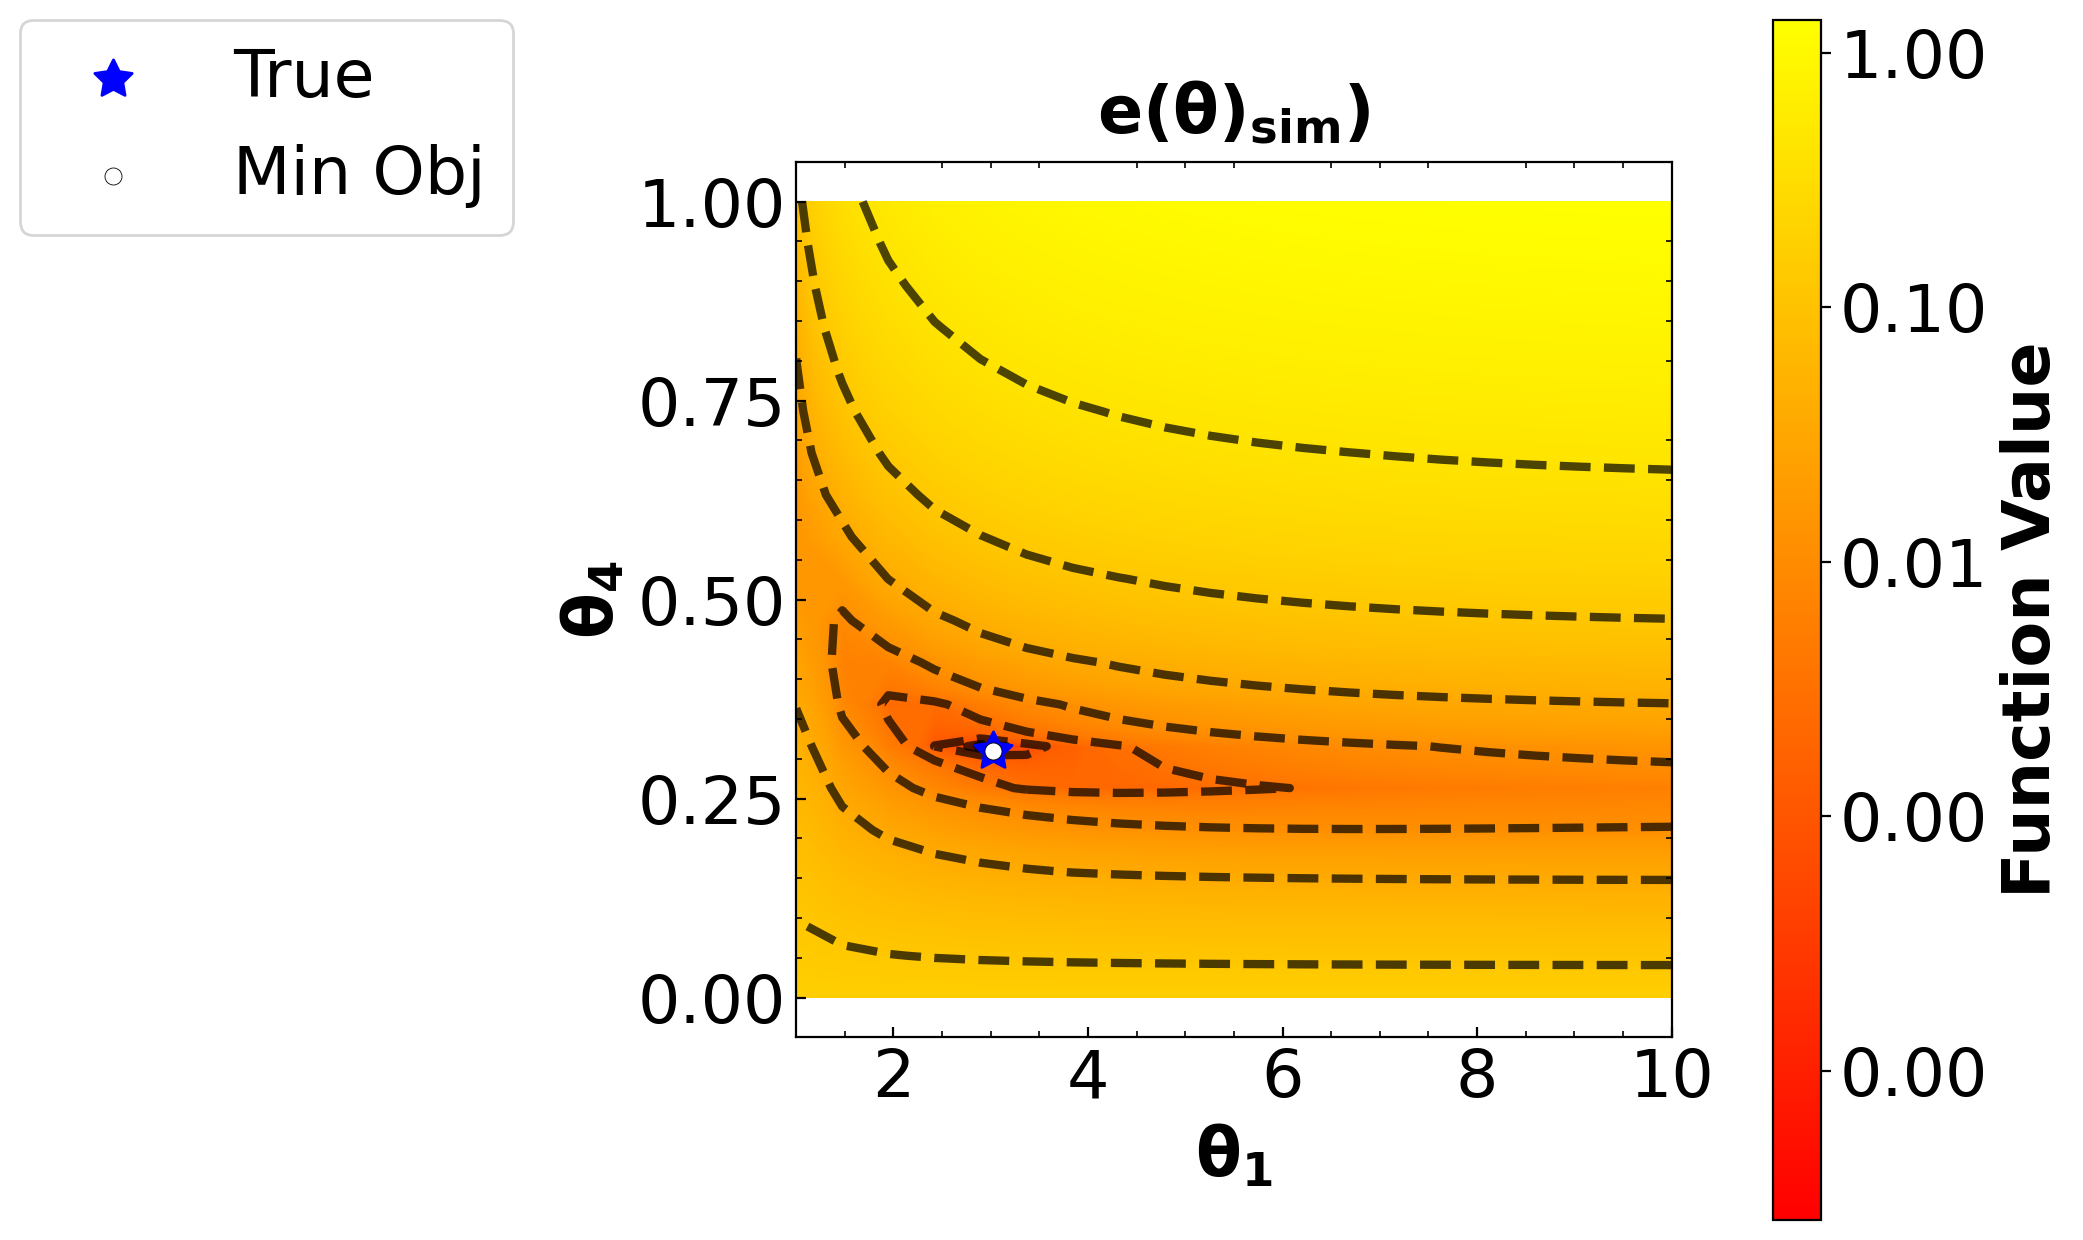

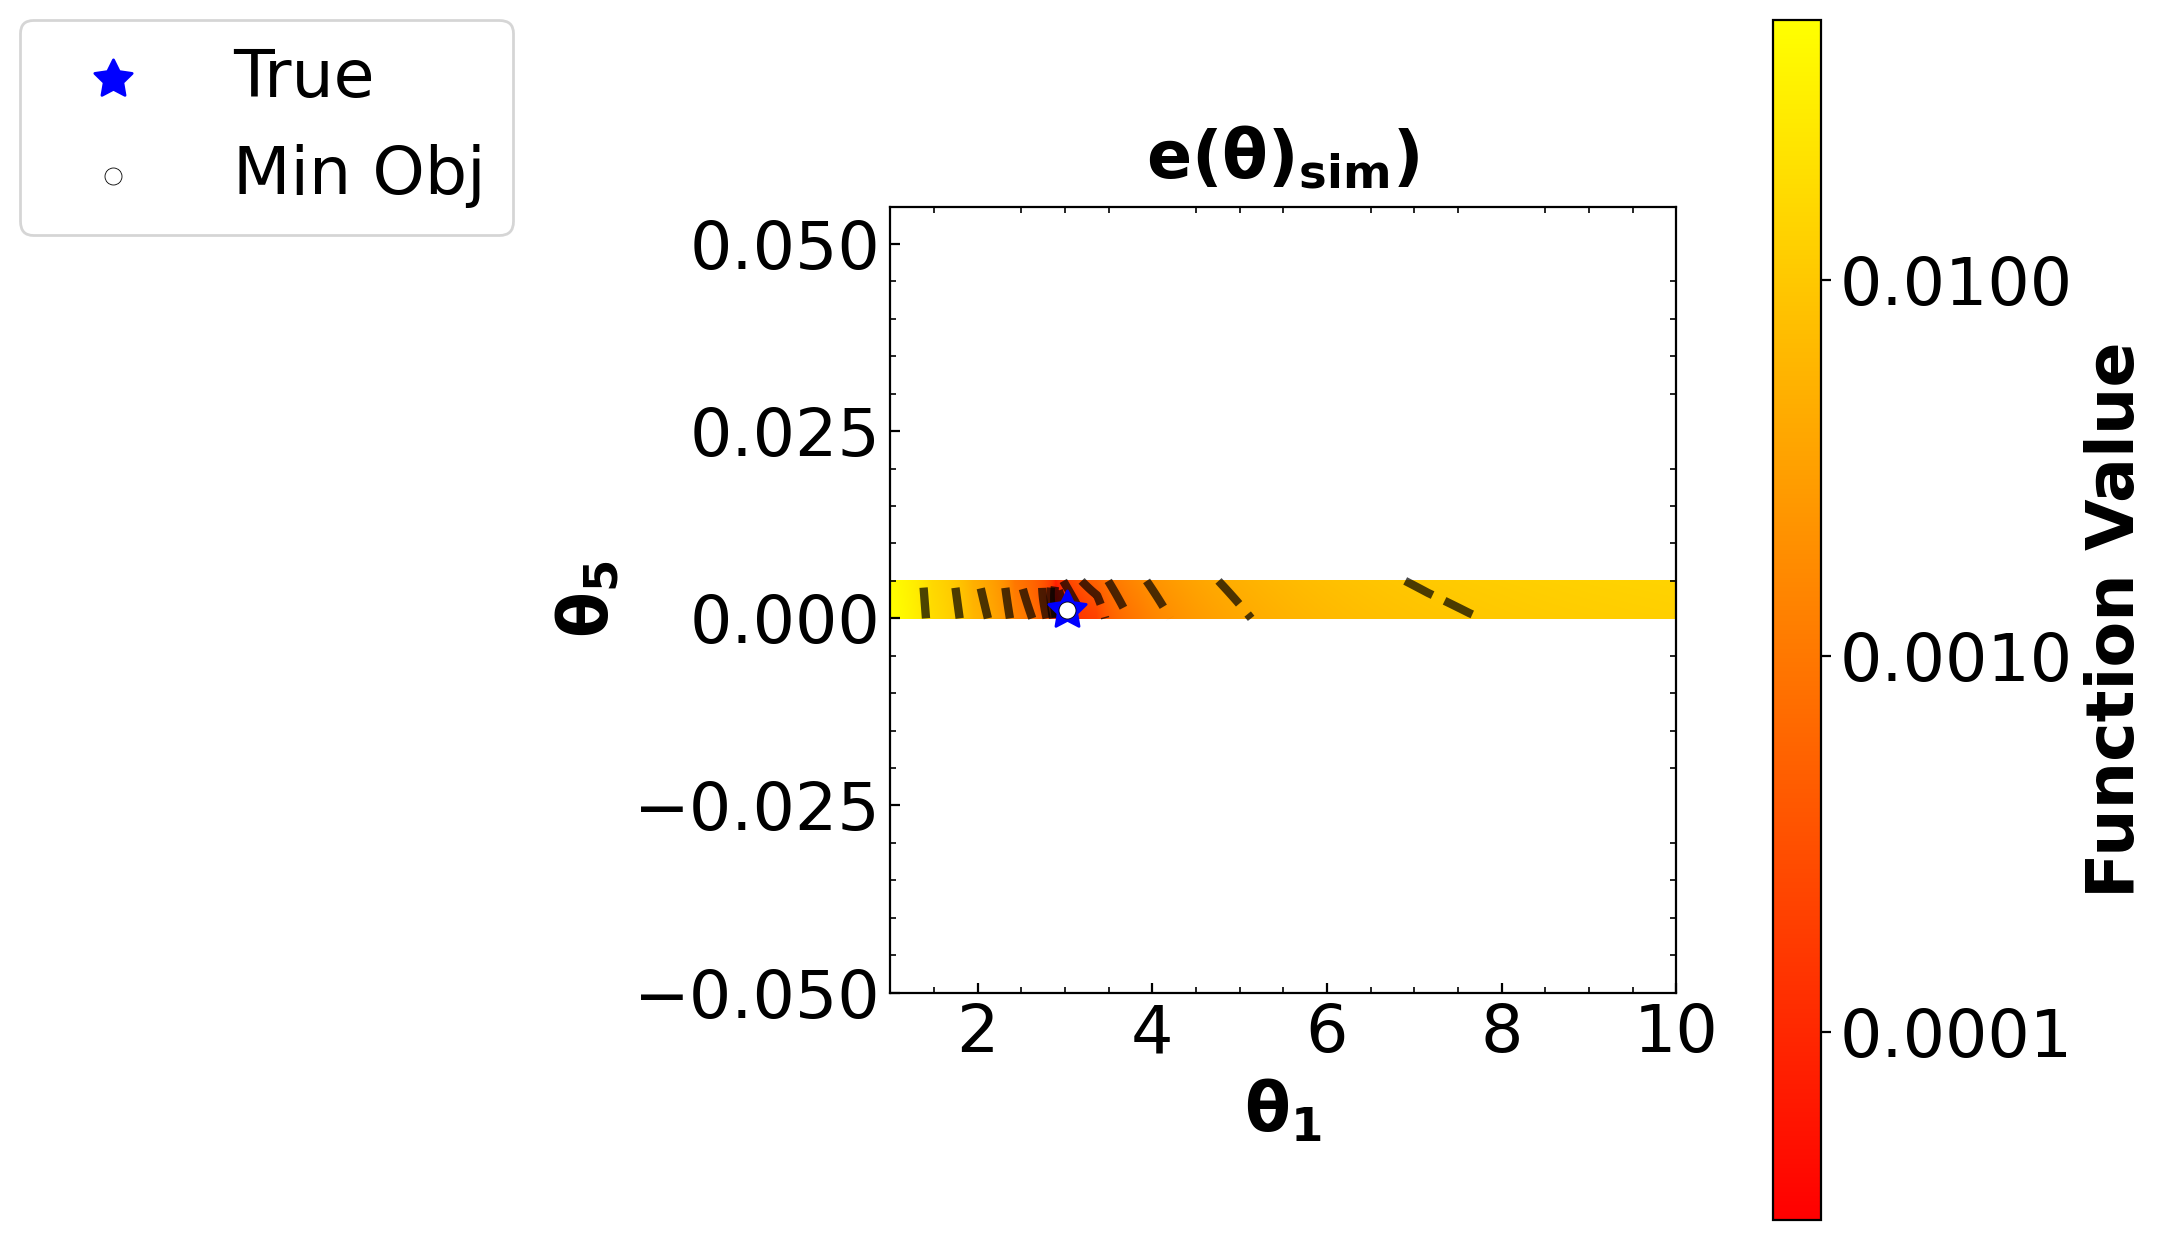

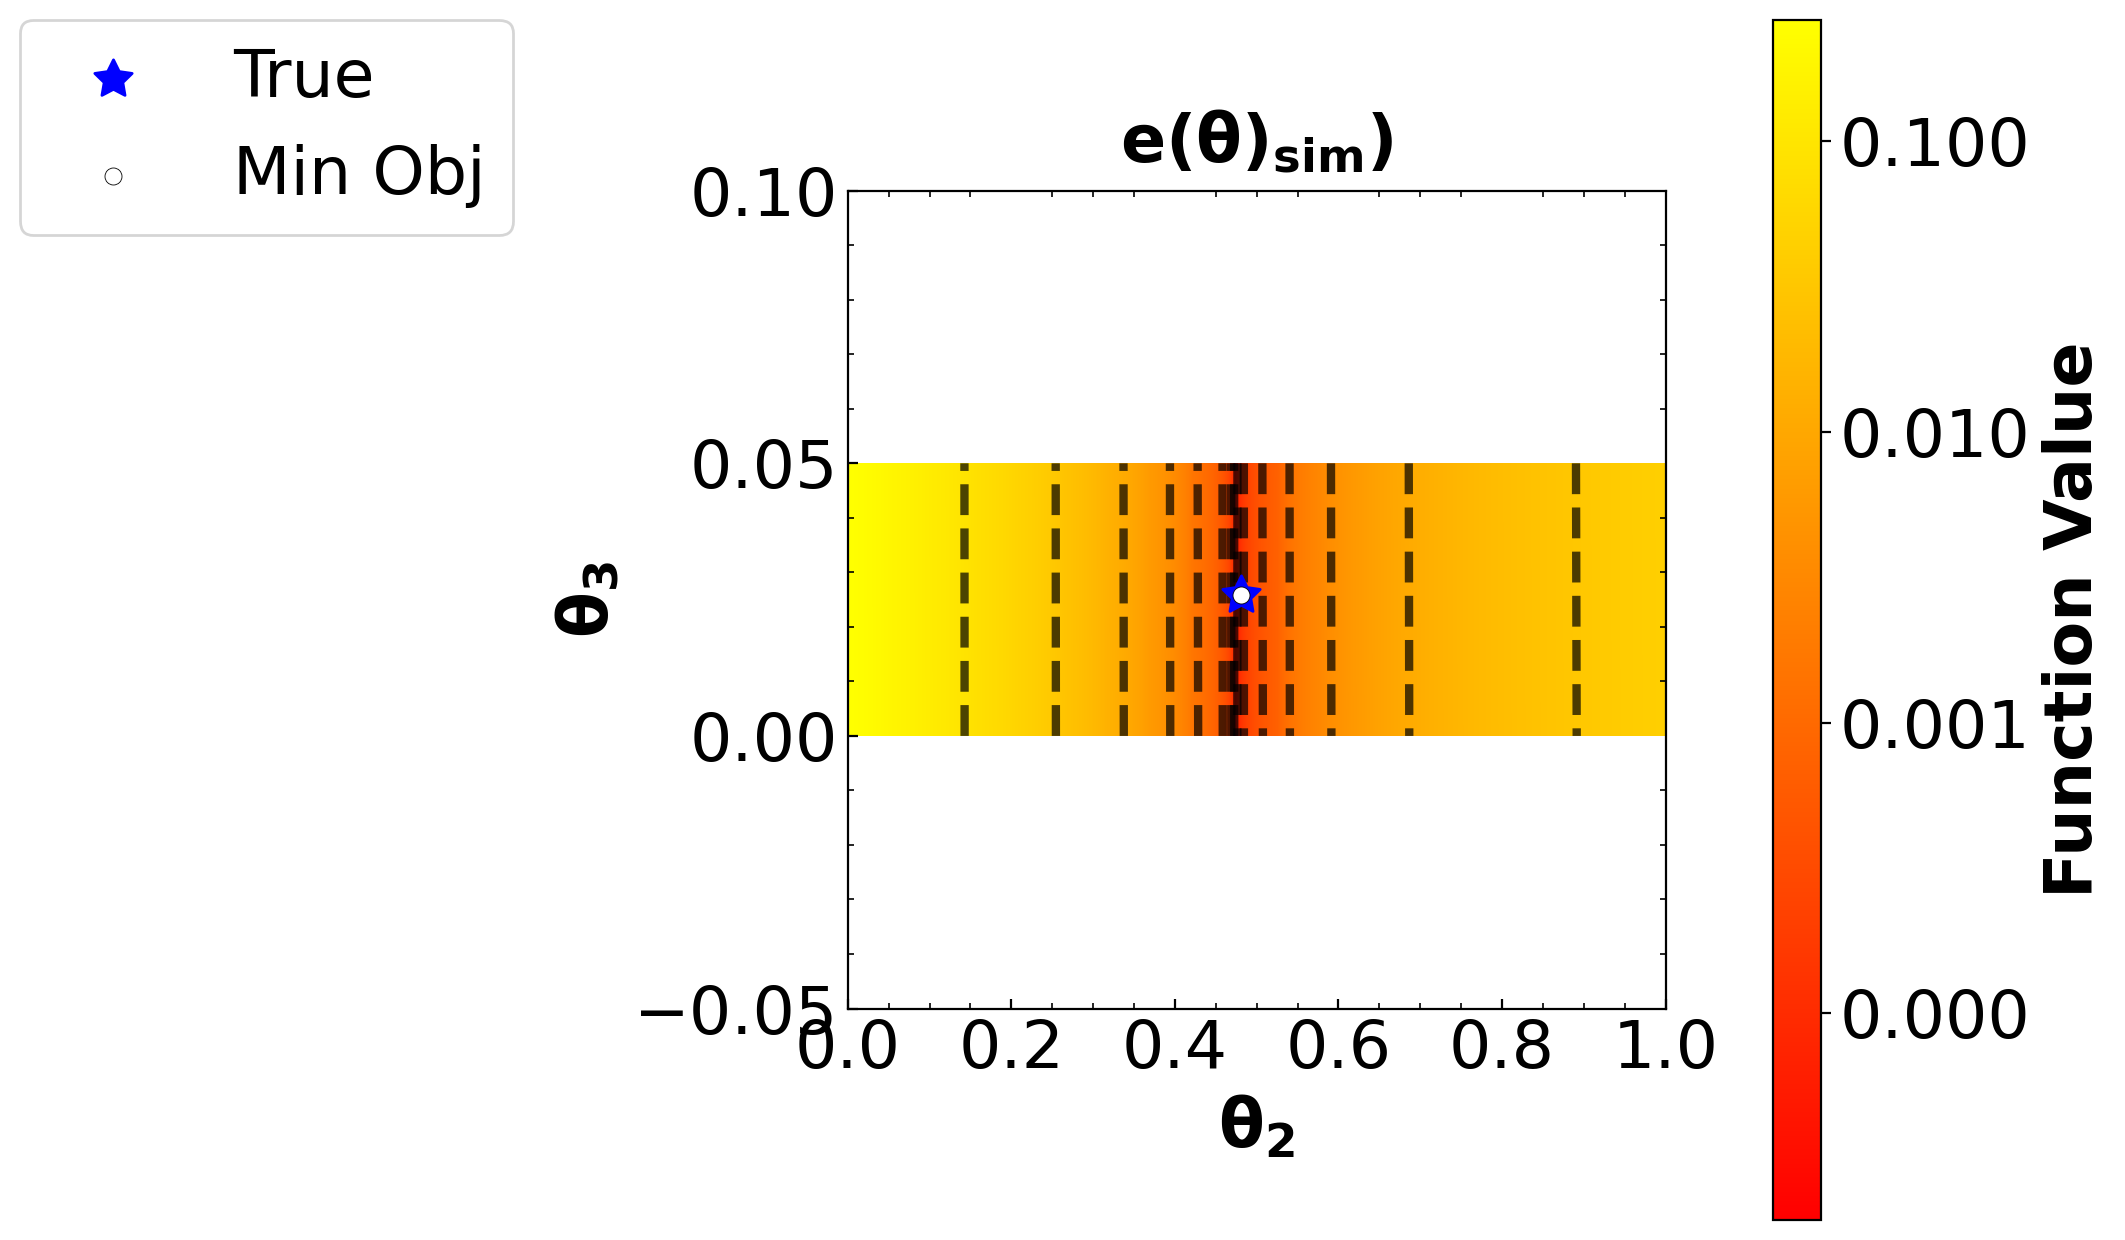

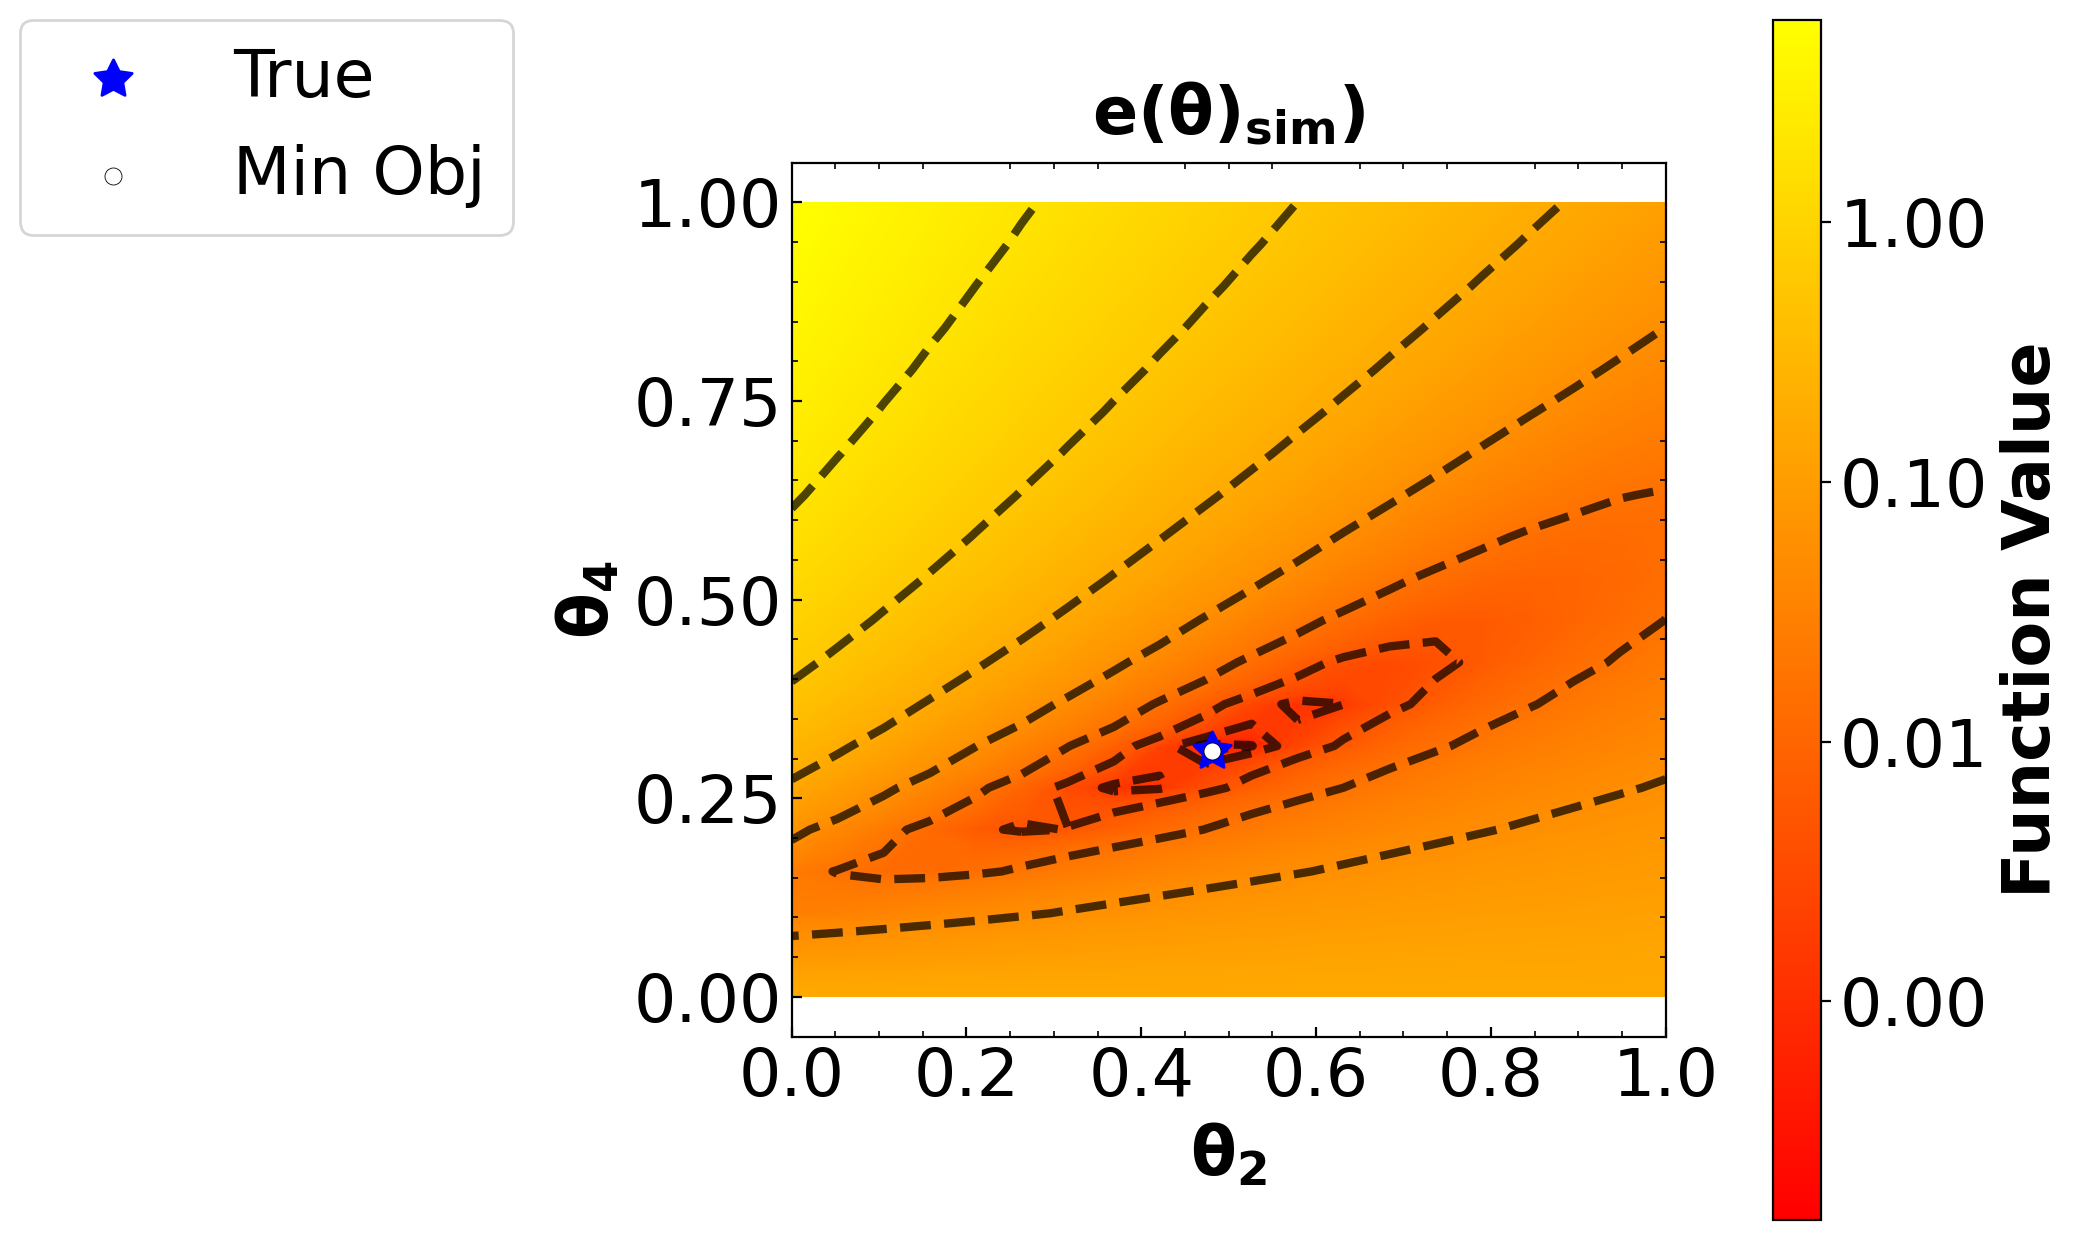

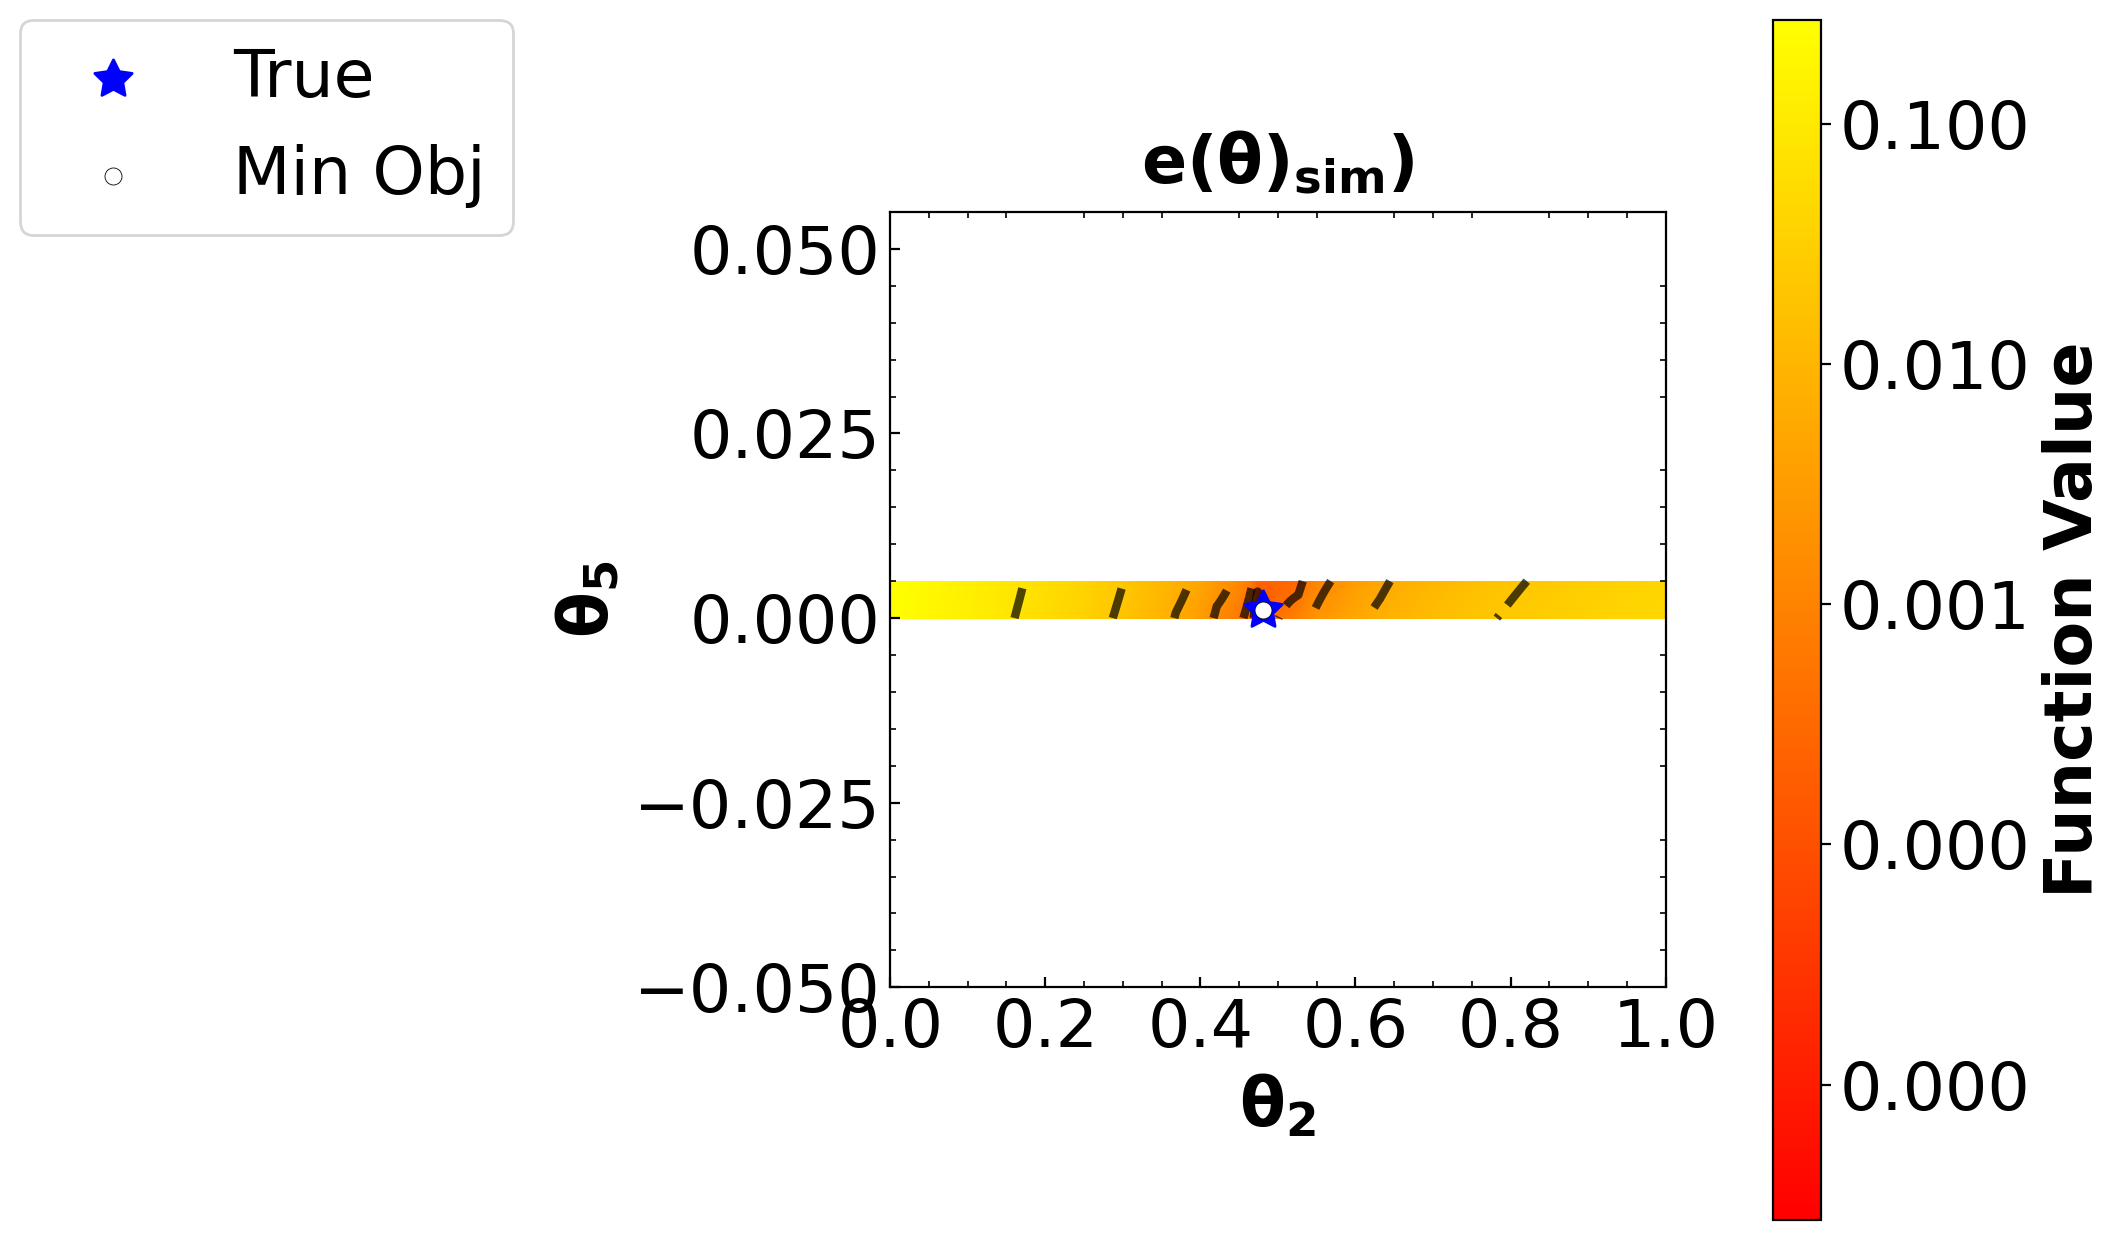

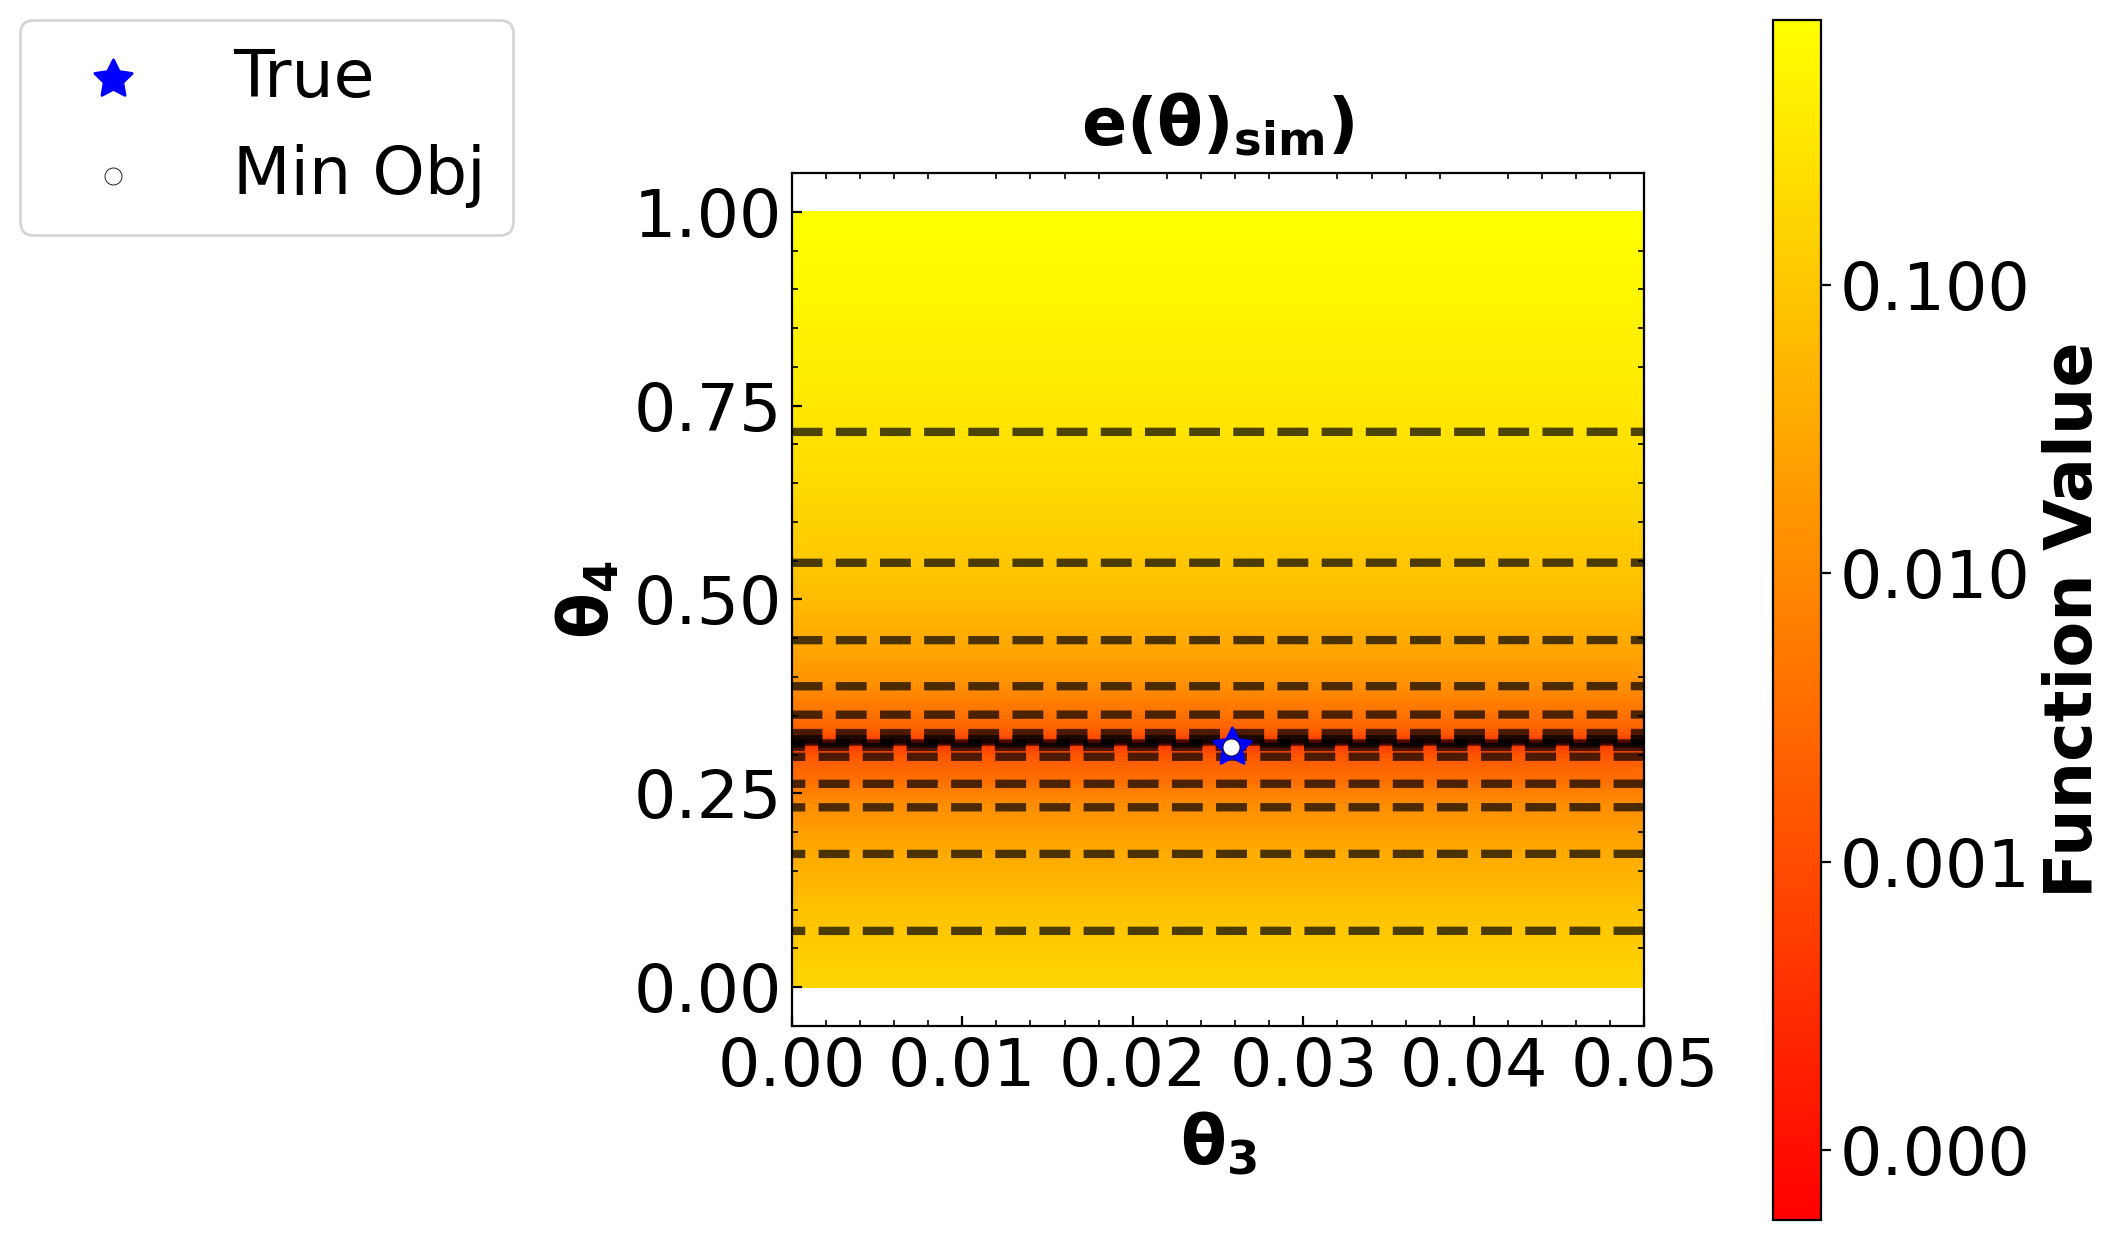

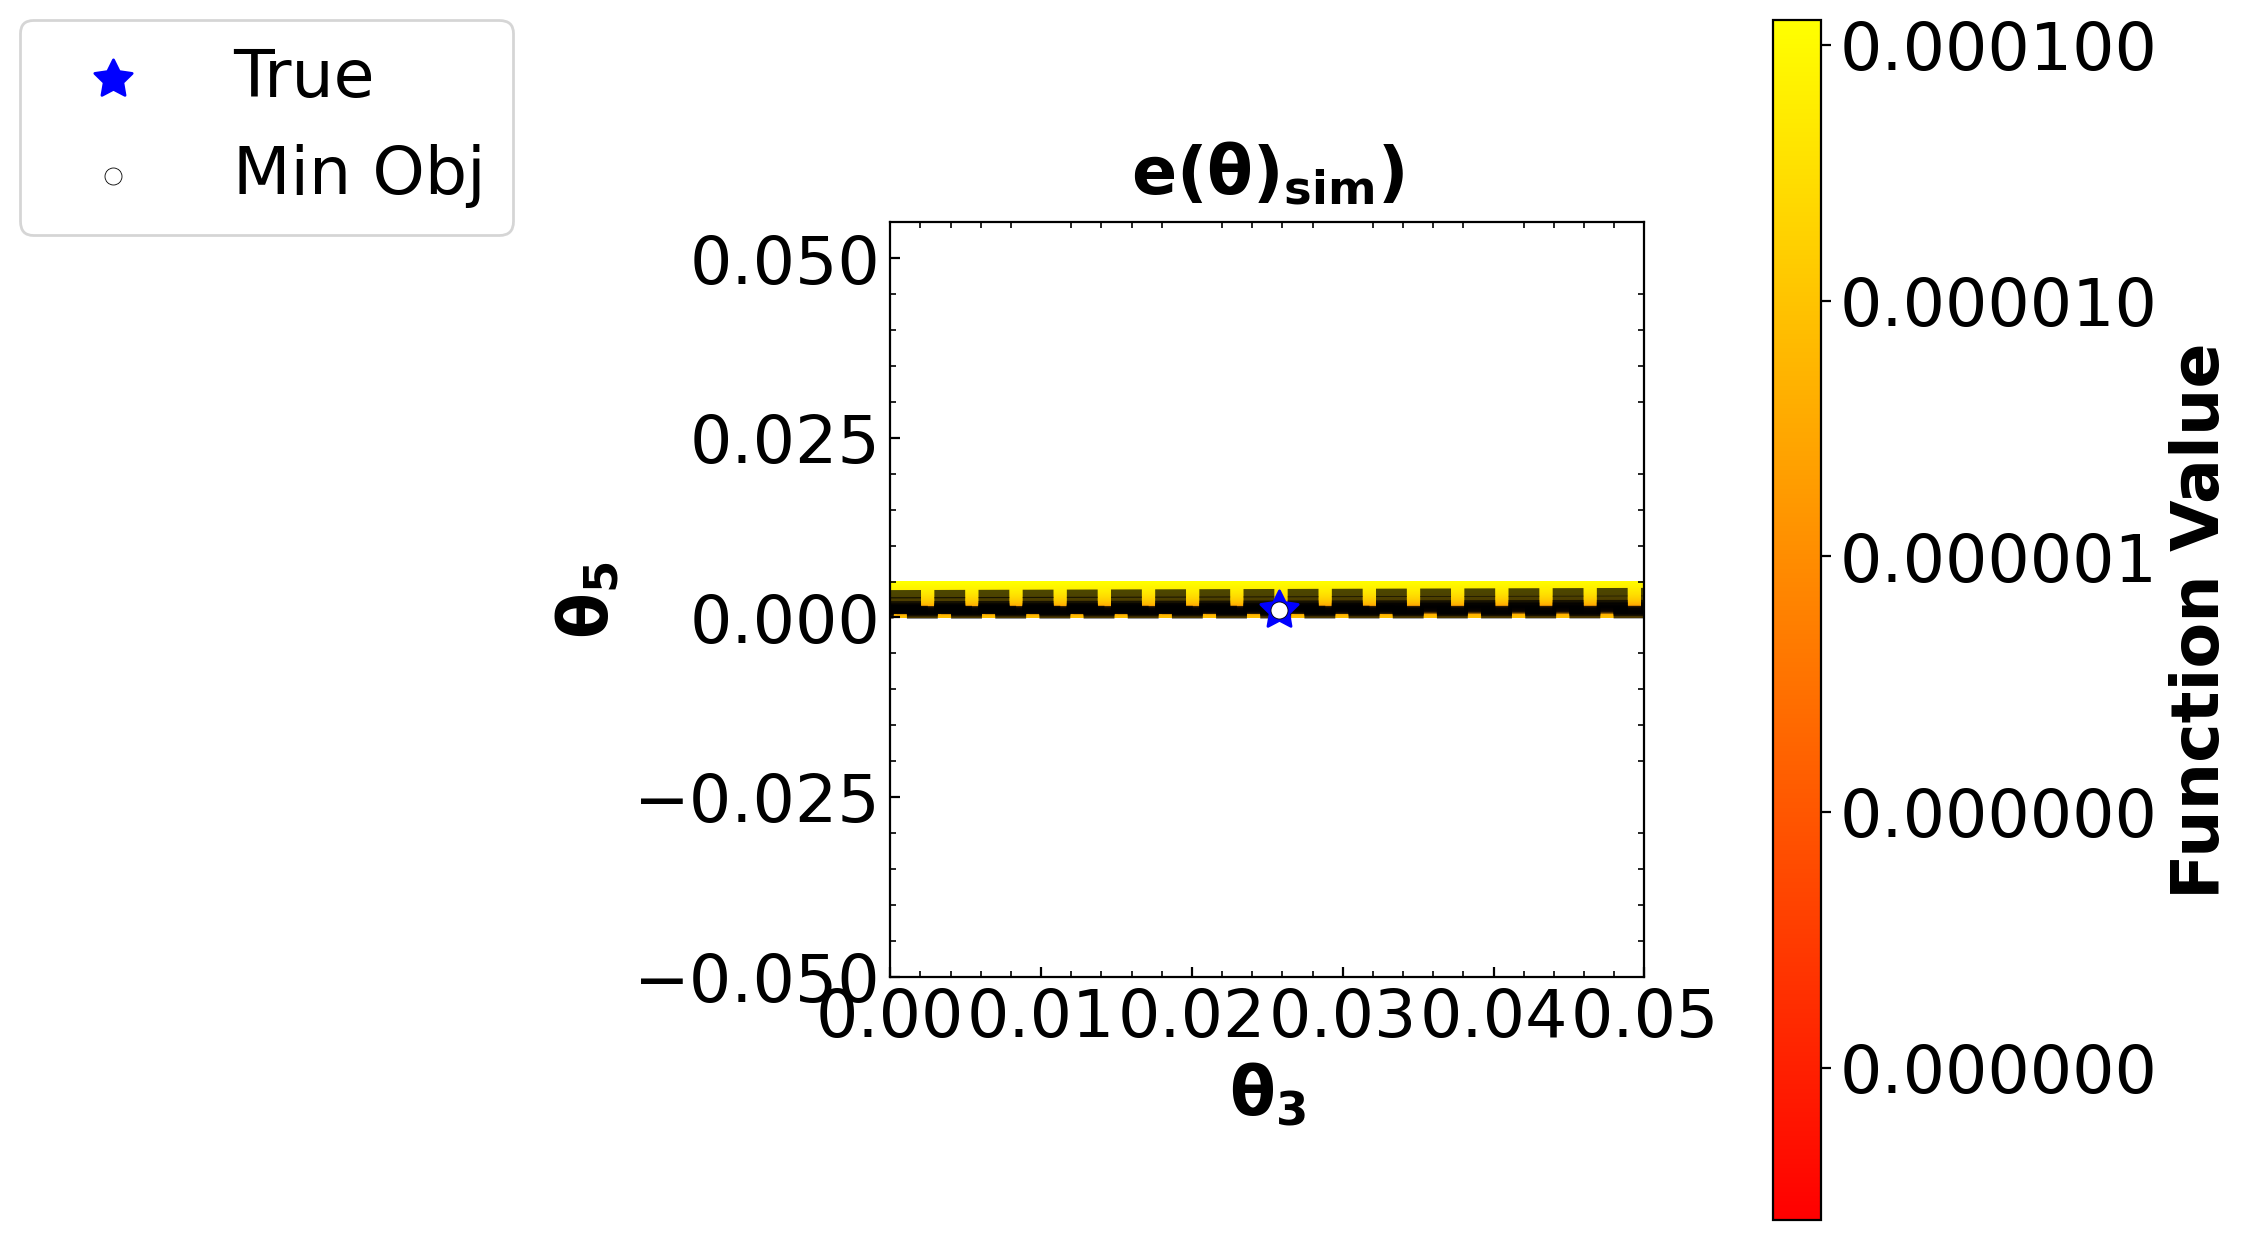

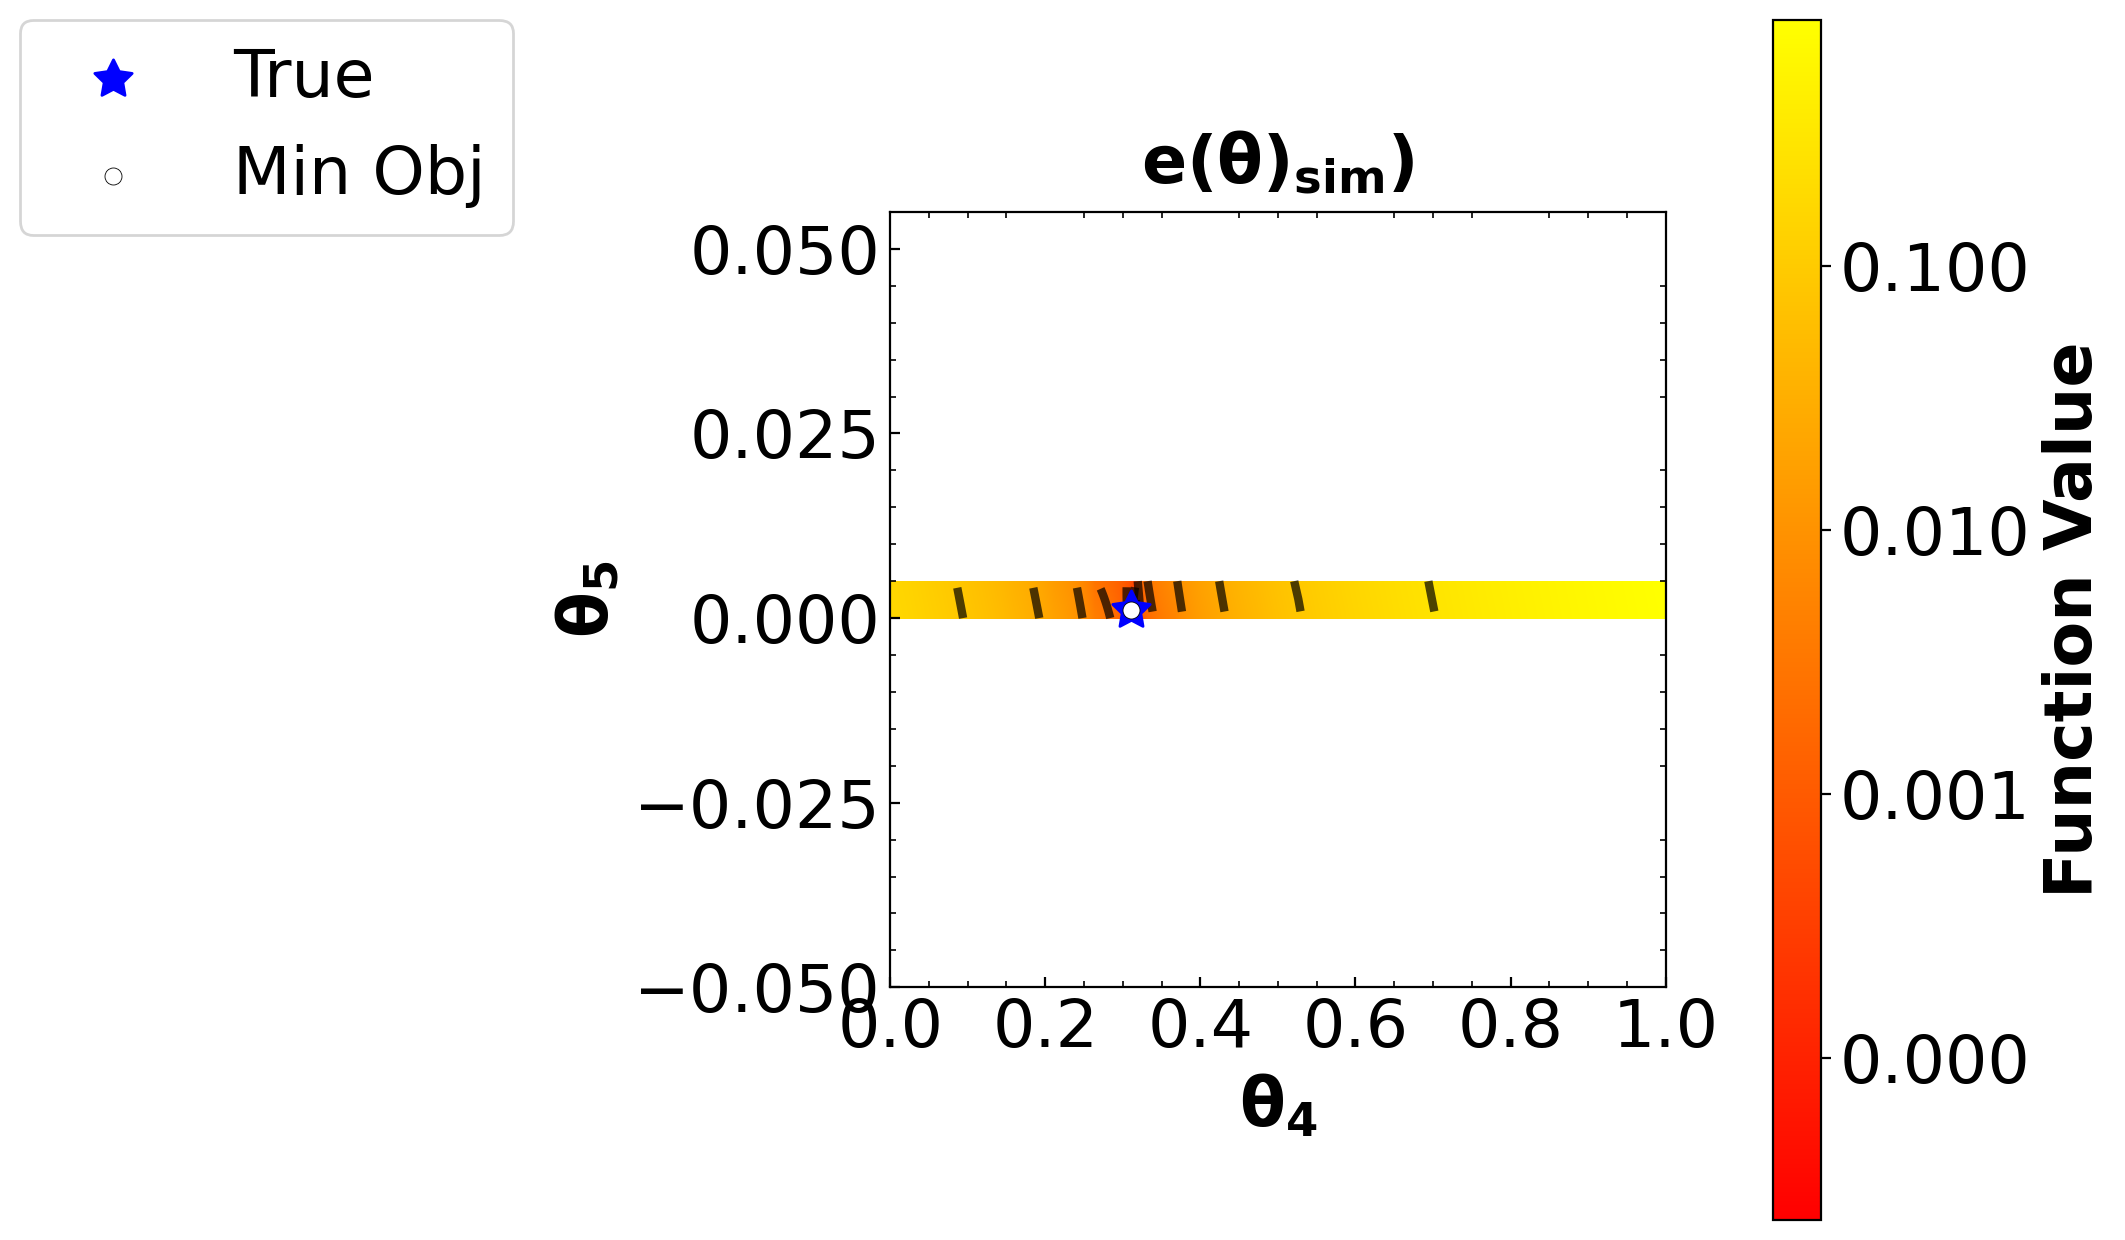

In [28]:
#New Cell
log_data = False
# save_figure = True
save_figure = False

#Get Number of pairs
combos = list(combinations(dim_list, 2))
pairs = len((list(combinations(dim_list, 2))))

#For each pair
for pair in range(pairs):
    #Make a meshgrid for each parameter
    idcs_to_plot = [int(combos[pair][i]) for i in range(len(combos[pair]))]
    theta_data = heat_map_data_dict[hm_data_keys[pair]].reshape(n_points, n_points, -1).T
    theta_mesh = np.take(theta_data, list(combos[pair]), axis=0)
    
    sse_sim = sse_func(heat_map_data_dict[hm_data_keys[pair]], theta_ref, indeces_to_consider, Xexp.reshape(-1,1), Yexp)
    param_names = theta_true_names[idcs_to_plot]
    
    title = "Heat Map Pair " + "-".join(map(str, param_names))
    title = None

    z = np.array([sse_sim])
    # print(np.amin(z), np.amax(z))
    if log_data == True:
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")"]
        z = np.log(z)
    else:
        z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")"]
    
#     z_save_names = ["sse_sim", "sse_nlr"]
#     path_end = '-'.join(z_save_names) 
    levels = [100]

    param_info_dict = {"true":theta_true, "min_sse":nlr_theta, "names":param_names, "idcs":idcs_to_plot}
    plotters.plot_nlr_heat_maps(theta_mesh, z, z_titles, levels, param_info_dict, log_data = False)

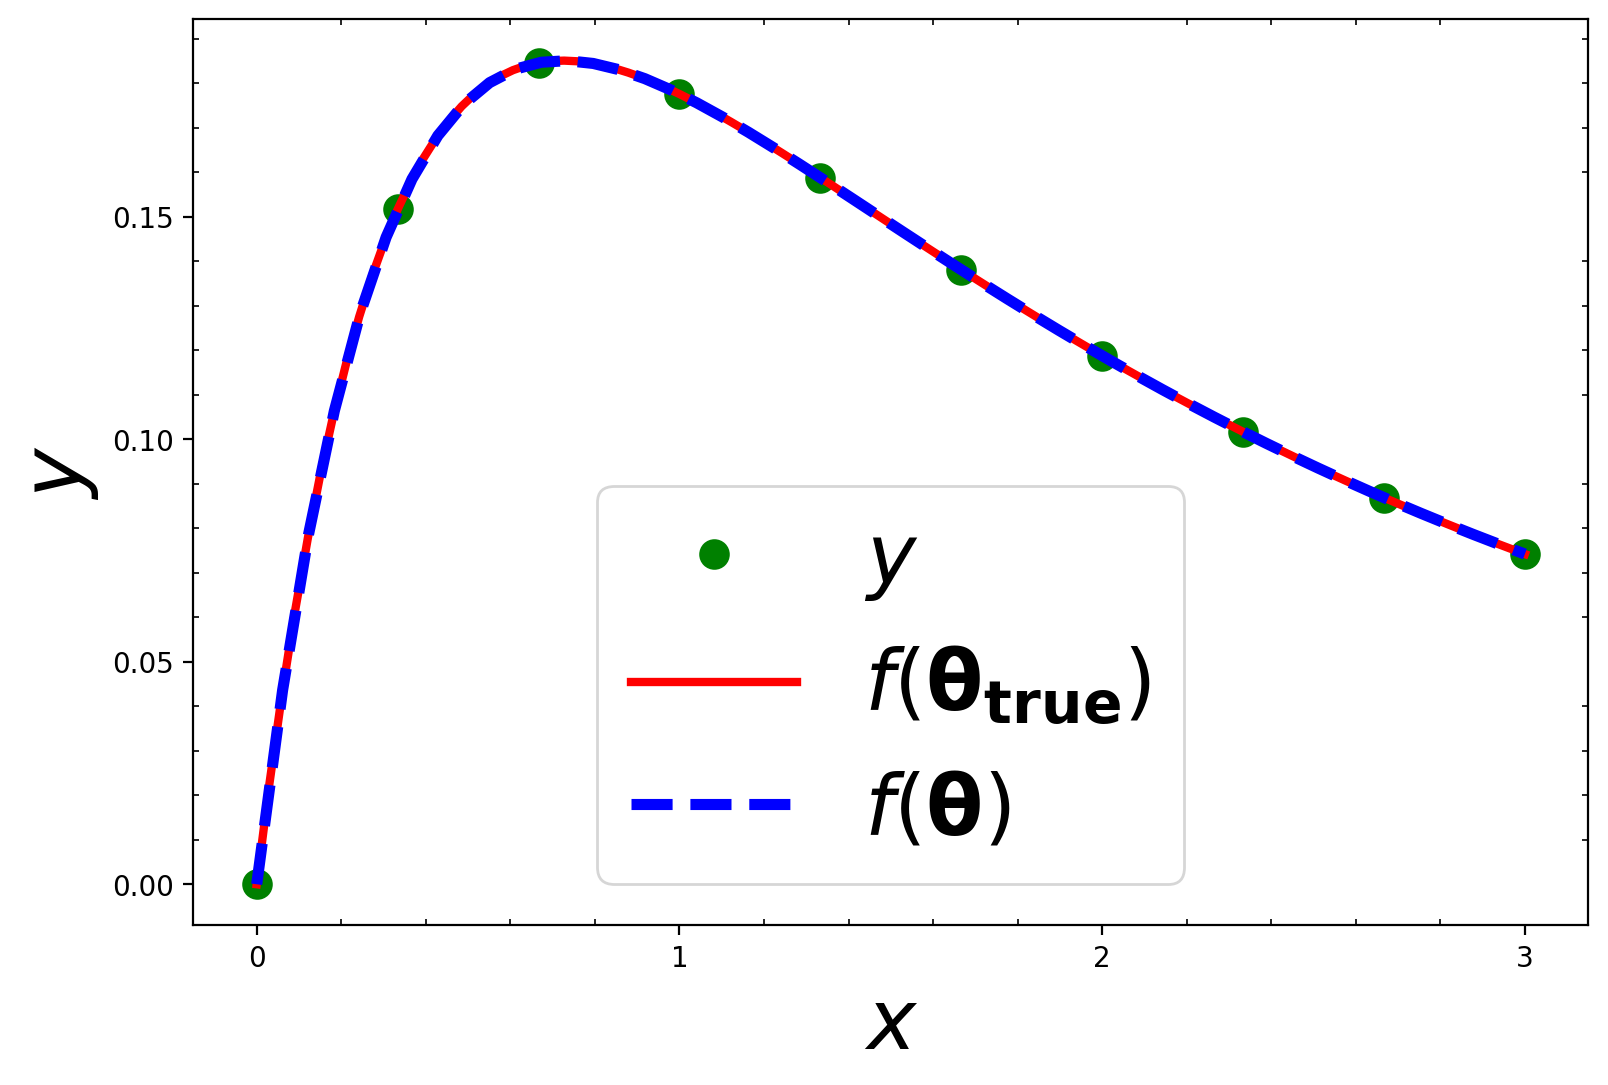

SSE =  6.220564534675394e-19


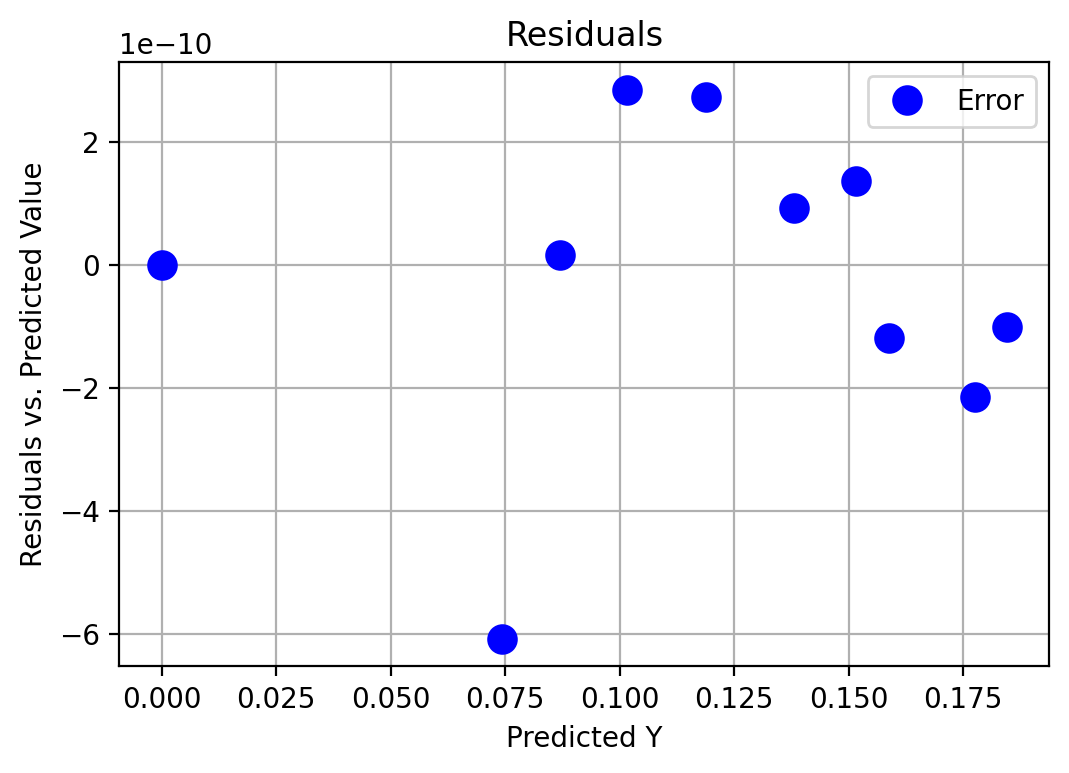

In [29]:
# create plot and compare predictions and experiments
X_pred = np.linspace(bounds_x[0], bounds_x[1]).reshape(-1,1)
Y_pred = model(nlr_theta, theta_true, X_pred, indeces_to_consider).flatten()
plt.figure(figsize = (9,6))
plt.plot(Xexp,Yexp,'.g',markersize=20,label=r'$y$')
plt.plot(X,Y,'r-',linewidth=3,label=r'$f(\mathbf{\theta_{true}})$')
plt.plot(X_pred,Y_pred,'--b',linewidth=4,label=r'$f(\mathbf{\theta})$')
# plt.title("Predictions with $\\theta = [0.994,-1.00]$ vs Synthetic Data")
# plt.title("Predictions with $\\theta = [0.802,-0.757]$ vs Synthetic Data")
plt.legend(loc = "best", fontsize=30) #(bbox_to_anchor=(1.04, 1), borderaxespad=0
plt.xlabel(r'$x$',fontsize=30,fontweight='bold')
plt.ylabel(r'$y$',fontsize=30,fontweight='bold')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
# plt.grid(True)

# plt.savefig("Figures/sim_true_comp_poster.png", dpi=300, bbox_inches='tight')
plt.show()


##New Cell

#Plot error
print("SSE = ", np.sum(error**2))
plt.plot(Y_nlr_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
sigre = np.maximum(std**2, 0.01)
MSE = (error.T @ error)/(len(error) - 2)
Hess = Solution.jac.T @ Solution.jac
Covar = sigre * np.linalg.inv(Hess)
FIM = (1/sigre)*Hess
eigvals, eigvecs = np.linalg.eig(FIM)
k = np.max(eigvals)/np.min(eigvals)
print("MSE = ", MSE)
print("Experimental Variance = ", sigre)
print("Parameter Prediction Standard Deviation: \n", np.sqrt(np.diag(Covar)))
print("Covariance matrix:\n",Covar)
print("Det(FIM) = ", np.linalg.det(FIM))
print("Eigen Values (FIM):\n", eigvals)
print("Eigen Vectors (FIM)\n", eigvecs)
print("Condition Number (FIM): ", k)
print("Degree of precision loss (log10(k) of FIM): ", math.log10(k))

MSE =  7.775705668344242e-20
Experimental Variance =  0.01
Parameter Prediction Standard Deviation: 
 [  32.145538     86.38610494 8007.87962611   64.4703295    70.17069158]
Covariance matrix:
 [[ 1.03333561e+03 -2.63741932e+03 -2.38640154e+05  1.92236568e+03
  -2.10905863e+03]
 [-2.63741932e+03  7.46255913e+03  6.89913607e+05 -5.55601543e+03
   6.05465582e+03]
 [-2.38640154e+05  6.89913607e+05  6.41261361e+07 -5.16250426e+05
   5.61742141e+05]
 [ 1.92236568e+03 -5.55601543e+03 -5.16250426e+05  4.15642339e+03
  -4.52293302e+03]
 [-2.10905863e+03  6.05465582e+03  5.61742141e+05 -4.52293302e+03
   4.92392596e+03]]
Det(FIM) =  1.8626315178070034e-07
Eigen Values (FIM):
 [8.70552759e+02 1.45704444e+01 1.72148290e-01 5.47153467e-03
 1.55900384e-08]
Eigen Vectors (FIM)
 [[ 0.01005573 -0.09137293 -0.45087427 -0.88783355 -0.00372094]
 [-0.20485104 -0.30106918 -0.81847471  0.44427112  0.01075725]
 [-0.00195536 -0.00734605  0.01133269 -0.00921173  0.99986445]
 [ 0.43352021 -0.87667463  0.2081489